## For inference not needed for now

In [1]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

# Get the debiased data, import libs, and show some samples

In [2]:
!cp /content/drive/MyDrive/LUMA/bias_detection_on_restructured_prompts.tsv ./dibiased_data.tsv
!cp /content/drive/MyDrive/LUMA/binary_classification_results.csv ./binary_classification_results.csv
!cp /content/drive/MyDrive/LUMA/multiclass_bias.csv ./multiclass_bias.csv
!cp /content/drive/MyDrive/LUMA/bias_detection.tsv ./bias_detection.tsv

In [3]:
import pandas as pd
import random
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [4]:
debiased_data = pd.read_csv('dibiased_data.tsv', sep='\t', index_col=0)
binary_classification_results = pd.read_csv('binary_classification_results.csv')
multiclass_bias = pd.read_csv('multiclass_bias.csv')
bias_detection = pd.read_csv('bias_detection.tsv', sep='\t', index_col=0)

In [5]:
print(f'lenght of debiased_data: {len(debiased_data)}')
print(f'lenght of binary_classification_results: {len(binary_classification_results)}')
print(f'lenght of multiclass_bias: {len(multiclass_bias)}')

lenght of debiased_data: 44346
lenght of binary_classification_results: 62875
lenght of multiclass_bias: 20170


In [6]:
debiased_data.bias.unique()

array(['no_bias', 'gender_bias', 'none', 'cultural_bias',
       'historical_bias', 'religious_bias',
       'stereotypical_appearance_bias', 'mythical_bias', 'religous_bias',
       'political_bias', 'diversity_bias', 'progressive_bias',
       'mythology_bias', 'stereotypical_bias', 'fictional_bias',
       'economic_bias', 'hate_speech', 'imposter_bias',
       'freedom_of_speech_bias', 'racial_bias', 'father_bias',
       'mythological_bias', 'magical_bias', 'supernatural_bias',
       'fictional_character_bias', 'genealogical_bias', 'noble_bias',
       'colonial_bias', 'celebrity_bias', 'knowledge_bias',
       'professional_bias', 'content_bias', 'ego_bias', 'name_bias',
       'character_bias', 'family_bias', 'fantasy_bias',
       'stereotypical_villain', 'philosophical_bias', 'ethical_bias',
       'existential_bias', 'authority_bias', 'political_influence_bias',
       'positive_fatherhood_bias', 'humility_bias', 'metaphorical_bias',
       'humanism_bias', 'moral_bias', 'fi

Use binary classification instead

In [7]:
debiased_data['bias'] = debiased_data['bias'].replace({'no_bias': 'non-biased', 'none': 'non-biased'})
debiased_data['bias'] = debiased_data['bias'].apply(lambda x: 'biased' if x != 'non-biased' else x)

In [8]:
bias_detection['bias'] = bias_detection['bias'].replace({'no_bias': 'non-biased', 'none': 'non-biased'})
bias_detection['bias'] = bias_detection['bias'].apply(lambda x: 'biased' if x != 'non-biased' else x)

In [9]:
bias_detection.bias.unique()

array(['non-biased', 'biased'], dtype=object)

In [10]:
debiased_data.bias.unique()

array(['non-biased', 'biased'], dtype=object)

In [11]:
idx = random.randint(0, len(debiased_data))
print(f'sample {idx} \nText: {debiased_data.loc[idx].text} \nLabel: {debiased_data.loc[idx].bias}')

sample 12464 
Text: The movie producer, Mark Burnett, has created a number of successful films. 
Label: non-biased


In [12]:
merged_clean = pd.merge(
    debiased_data,
    binary_classification_results,
    on=['text', 'label'],
    how='inner'
)

# Keep only the required columns
final_clean = merged_clean[['text', 'label', 'bias', 'results']]
final_clean.rename(columns={'bias': 'gemma'}, inplace=True)

<ipython-input-12-082e6a40af48>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_clean.rename(columns={'bias': 'gemma'}, inplace=True)


In [13]:
merged_dirty = pd.merge(
    bias_detection,
    binary_classification_results,
    on=['text', 'label'],
    how='inner'
)

# Keep only the required columns
final_dirty = merged_dirty[['text', 'label', 'bias', 'results']]
final_dirty.rename(columns={'bias': 'gemma'}, inplace=True)

<ipython-input-13-d415846baa21>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dirty.rename(columns={'bias': 'gemma'}, inplace=True)


In [14]:
final_dirty.label.unique()

array(['ship', 'fish', 'television', 'chair', 'house', 'train', 'snake',
       'bicycle', 'sea', 'forest', 'table', 'plain', 'cat', 'camel',
       'tank', 'telephone', 'cloud', 'fox', 'castle', 'lion', 'mountain',
       'road', 'bee', 'bridge', 'horse', 'whale', 'baby', 'truck', 'lamp',
       'bird', 'mouse', 'frog', 'bear', 'roses', 'bus', 'elephant',
       'palm', 'pine', 'rabbit', 'ray', 'dog', 'cattle', 'oak', 'clock',
       'bed', 'wolf'], dtype=object)

In [15]:
def get_bias_label(data, threshold = 0.9):
    # Extract label and score into separate columns
    data['dbias'] = data['results'].apply(lambda x: 'biased' if eval(x)['score'] > threshold else 'non-biased')
    return data

In [16]:
final_clean = get_bias_label(final_clean, threshold = 0.98).drop(columns=['results'])

<ipython-input-15-6cf9f11fe20d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dbias'] = data['results'].apply(lambda x: 'biased' if eval(x)['score'] > threshold else 'non-biased')


In [17]:
final_clean.dbias.unique(), final_clean.gemma.unique()

(array(['non-biased', 'biased'], dtype=object),
 array(['non-biased'], dtype=object))

In [18]:
final_dirty = get_bias_label(final_dirty, threshold = 0.98).drop(columns=['results'])

<ipython-input-15-6cf9f11fe20d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dbias'] = data['results'].apply(lambda x: 'biased' if eval(x)['score'] > threshold else 'non-biased')


In [19]:
final_dirty.dbias.unique(), final_dirty.gemma.unique()

(array(['non-biased', 'biased'], dtype=object),
 array(['non-biased', 'biased'], dtype=object))

In [20]:
def analyze_model_predictions(df):
    """
    Analyze and compare predictions between two models.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'label', 'dbias', and 'gemma'

    Returns:
    dict: Dictionary containing various analysis metrics
    """
    # Calculate overall agreement
    agreement = (df['dbias'] == df['gemma']).mean() * 100

    # Create confusion matrix between models
    confusion_matrix = pd.crosstab(
        df['dbias'],
        df['gemma'],
        margins=True
    )

    # Agreement by category/label
    agreement_by_label = df.groupby('label').apply(
        lambda x: (x['dbias'] == x['gemma']).mean() * 100
    ).to_dict()

    # Distribution of predictions for each model by label
    distribution_a = df.groupby(['label', 'dbias']).size().unstack(fill_value=0)
    distribution_b = df.groupby(['label', 'gemma']).size().unstack(fill_value=0)

    # Calculate disagreement cases
    disagreements = df[df['dbias'] != df['gemma']]

    return {
        'overall_agreement': agreement,
        'confusion_matrix': confusion_matrix,
        'agreement_by_label': agreement_by_label,
        'distribution_a': distribution_a,
        'distribution_b': distribution_b,
        'disagreements': disagreements
    }

def visualize_comparisons(analysis_results):
    """
    Create visualizations for model comparison results with consistent colors
    """
    # Define consistent color mapping
    color_map = {
        'biased': '#FFA500',  # Orange for biased
        'non-biased': '#08306b',  # Blue for non-biased
    }

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion Matrix Heatmap
    sns.heatmap(
        analysis_results['confusion_matrix'].iloc[:-1, :-1],
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Confusion Matrix between Dbias and Gemma models')

    # Agreement by Label Bar Plot
    agreement_data = pd.Series(analysis_results['agreement_by_label'])
    agreement_data.plot(
        kind='bar',
        ax=axes[0, 1],
        color='#08306b'  # Using the same blue for consistency
    )
    axes[0, 1].set_title('Agreement Percentage by Label')
    axes[0, 1].set_ylabel('Agreement (%)')

    # Desired column order
    desired_order = ['non-biased', 'biased']

    # Distribution plots for each model
    for idx, (distribution_key, title) in enumerate([
        ('distribution_a', 'Distribution of Predictions - Dbias model'),
        ('distribution_b', 'Distribution of Predictions - Gemma model')
    ]):
        distribution = analysis_results[distribution_key]

        # Get available columns in the desired order
        available_columns = [col for col in desired_order if col in distribution.columns]

        # Create color list for available columns
        colors = [color_map[col] for col in available_columns]

        # Plot with available columns
        if len(available_columns) > 0:  # Only plot if there are columns to plot
            distribution[available_columns].plot(
                kind='bar',
                stacked=True,
                ax=axes[1, idx],
                color=colors
            )

        axes[1, idx].set_title(title)
        axes[1, idx].set_ylabel('Count')
        axes[1, idx].legend(title='')

    # Adjust layout
    plt.tight_layout()
    return fig

<ipython-input-20-fb8ee7cadb28>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agreement_by_label = df.groupby('label').apply(


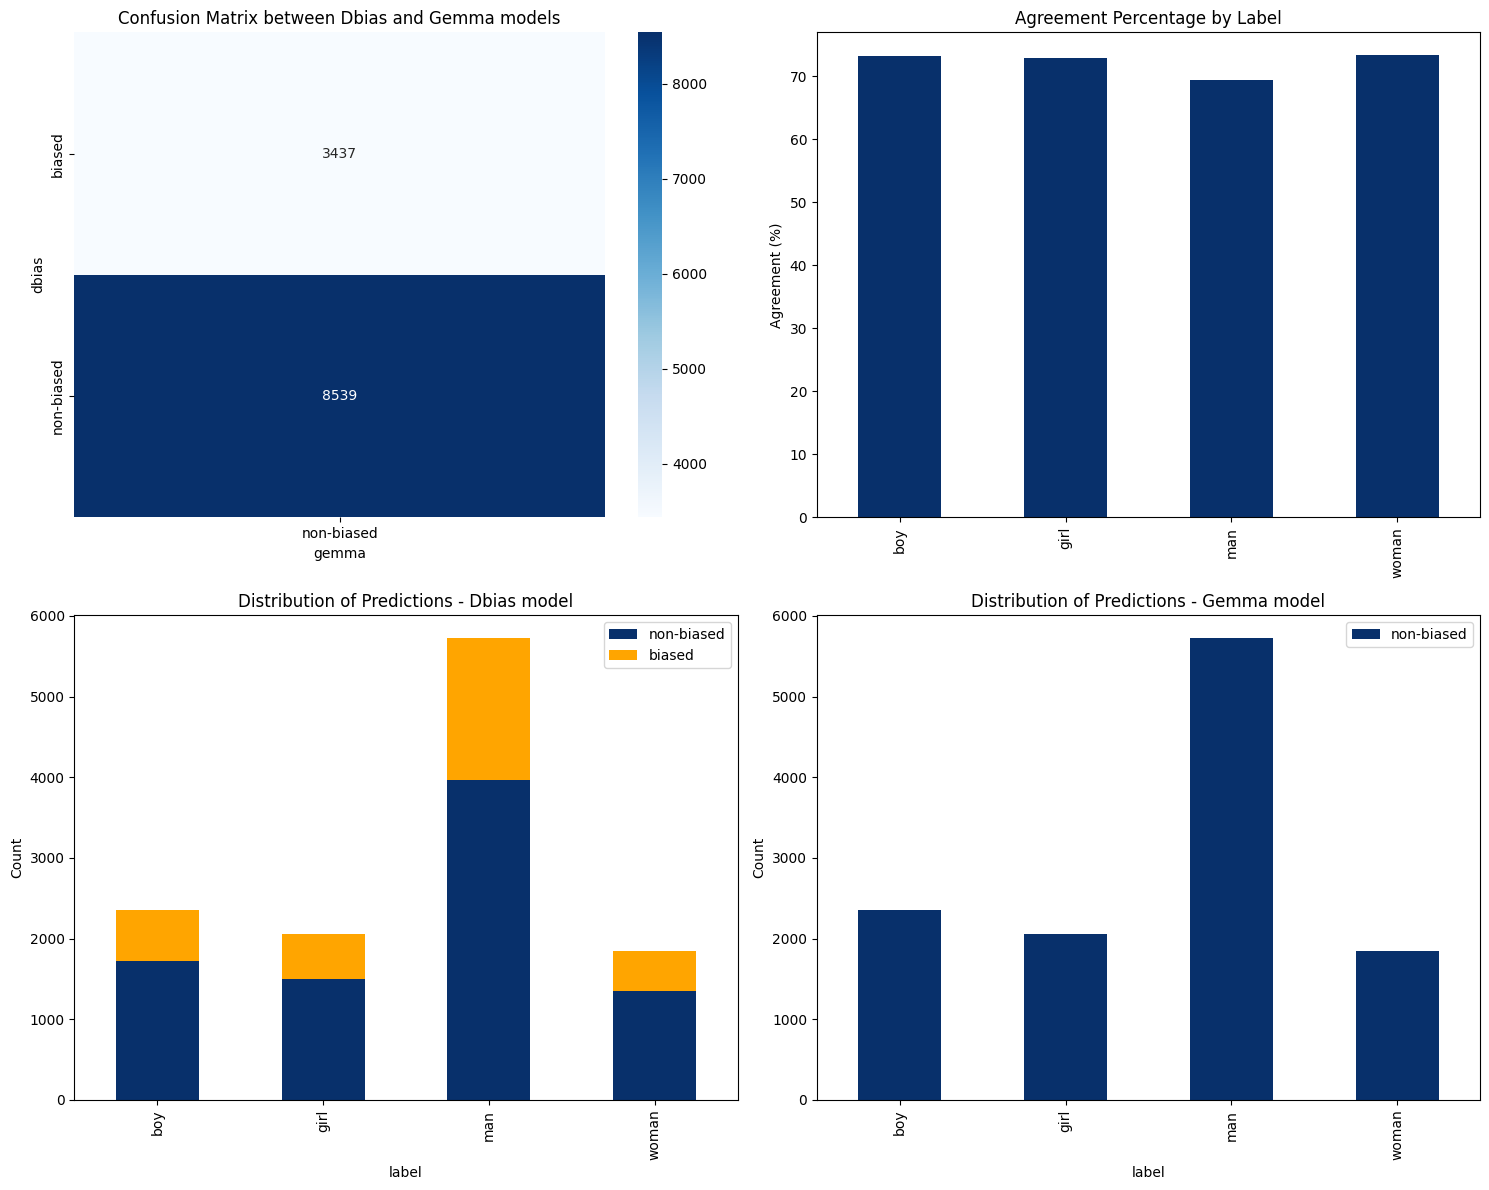

In [21]:
results = analyze_model_predictions(final_clean)
fig = visualize_comparisons(results)
fig.savefig("comp_new.svg")
plt.show()

<ipython-input-20-fb8ee7cadb28>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agreement_by_label = df.groupby('label').apply(


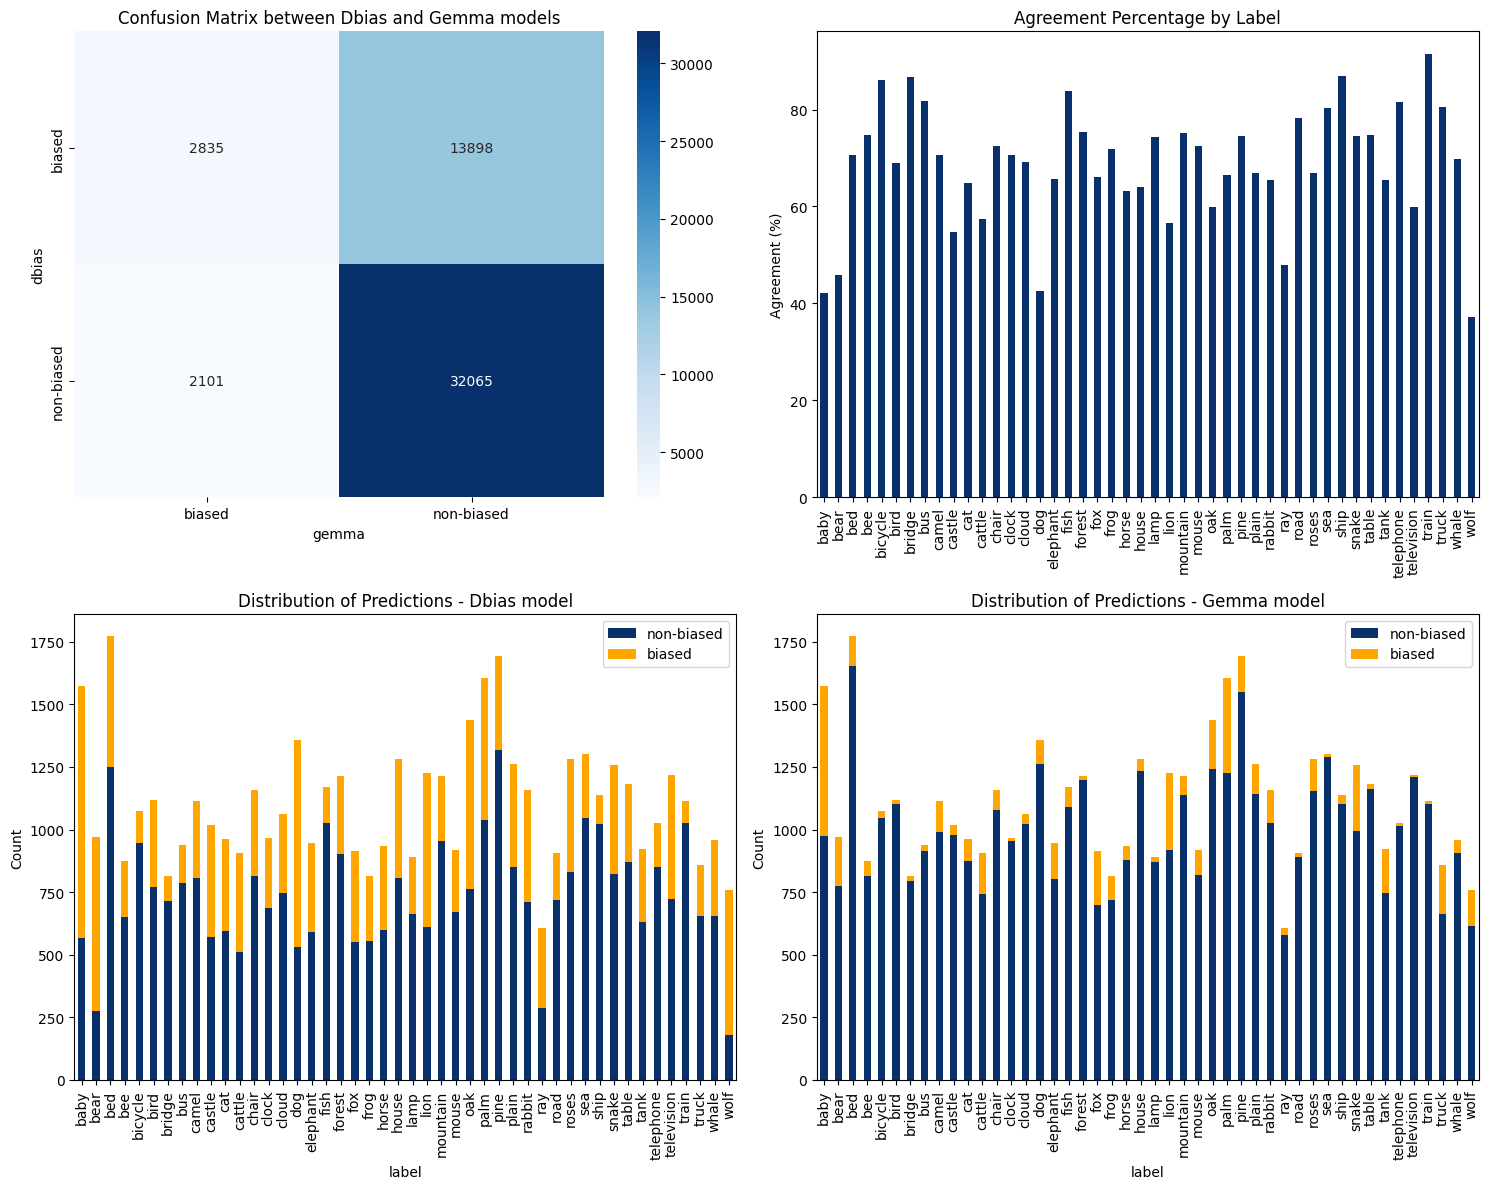

In [22]:
results = analyze_model_predictions(final_dirty)
fig = visualize_comparisons(results)
fig.savefig("comp_old.svg")
plt.show()